In [2]:
import torch

In [3]:
import torch

# List all available GPUs
if torch.cuda.is_available():
    print("Available CUDA Devices:")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA devices are available")

# Check CUDA_VISIBLE_DEVICES environment variable
import os
cuda_visible_devices = os.getenv('CUDA_VISIBLE_DEVICES')
print("CUDA_VISIBLE_DEVICES:", cuda_visible_devices if cuda_visible_devices is not None else "Not set (All GPUs are visible)")


Available CUDA Devices:
Device 0: NVIDIA GeForce RTX 3080 Ti
CUDA_VISIBLE_DEVICES: Not set (All GPUs are visible)


In [4]:
hf_dataset_identifier = "unreal-hug/REAL_DATASET_SEG_401_6_lbls"
# semantic_dataset.push_to_hub(hf_dataset_identifier)

In [5]:
from datasets import load_dataset

ds = load_dataset(hf_dataset_identifier)

In [6]:
from torchvision.transforms import ColorJitter, RandomRotation, RandomHorizontalFlip
import torchvision.transforms.functional as TF
from PIL import Image

class NewProcessor:
    def __init__(self):
        self.jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 
        self.flip = RandomHorizontalFlip(p=0.5)
        self.rotation = RandomRotation(degrees=[-15,15], center=[128, 20])
        
    def __call__(self, image, label):
        image = TF.pil_to_tensor(self.jitter(image)) # size [3, 256, 256], unit8
        label = TF.pil_to_tensor(label) # [1, 256, 256], uint32
        # print(image.dtype, label.dtype)
        merged = torch.cat((image, label), dim=0) # [4, 256, 256]
        merged = self.flip(merged) 
        merged = self.rotation(merged)
        image = TF.to_pil_image(merged[:3].to(dtype=torch.uint8))
        label = TF.to_pil_image(merged[3])
        return image, label

In [16]:
image = ds['train'][1]['pixel_values']
mask = ds['train'][1]['label']
new_transforms = NewProcessor()
new_image, new_mask = new_transforms(image, mask)

In [25]:
from PIL import Image
import numpy as np

def inspect_image(file_path):
    # Load the image
    img = file_path

    # Display basic information about the image
    print(f"Format: {img.format}")  # Output format (e.g., JPEG, PNG)
    print(f"Mode: {img.mode}")  # Output mode (e.g., L, RGB)
    print(f"Size: {img.size}")  # Output size (width, height)

    # Convert the image to a numpy array for detailed analysis
    img_array = np.array(img)

    # Print array properties
    print(f"Array Shape: {img_array.shape}")  # Shape of the array
    print(f"Data Type: {img_array.dtype}")  # Data type of the array elements

    # Calculate and print unique values and their counts
    unique, counts = np.unique(img_array, return_counts=True)
    unique_counts = dict(zip(unique, counts))
    print("Unique pixel values and counts:")
    for value, count in unique_counts.items():
        print(f"Value: {value}, Count: {count}")

# Specify the path to your image file
# file_path = 'path_to_your_image_file.png'
inspect_image(new_mask)


AttributeError: read

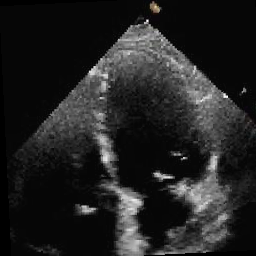

In [17]:
new_image

In [19]:
from PIL import Image
import numpy as np

# Load your mask image - assuming it's in a compatible format or already a numpy array
mask_array = np.array(new_mask)

# Scale the mask to the full 0-255 range if the mask is not already in this range
scaled_mask = 255 * (mask_array / mask_array.max())  # Normalizes the max value to 255

# Convert scaled numpy array back to an image
visible_mask = Image.fromarray(scaled_mask.astype(np.uint8))

# visible_mask.save('path_to_save_visible_mask.png')
visible_mask.show()

print("Adjusted mask is saved and displayed.")

C:\Users\rogbeast\AppData\Local\Temp\ipykernel_15424\2741452669.py:8: RuntimeWarning: invalid value encountered in divide
  scaled_mask = 255 * (mask_array / mask_array.max())  # Normalizes the max value to 255
C:\Users\rogbeast\AppData\Local\Temp\ipykernel_15424\2741452669.py:11: RuntimeWarning: invalid value encountered in cast
  visible_mask = Image.fromarray(scaled_mask.astype(np.uint8))


Adjusted mask is saved and displayed.


In [20]:
import numpy as np
from PIL import Image

# Load the mask image
mask_array = np.array(new_mask)

# Print unique values in the array
unique_values = np.unique(mask_array)
print("Unique values in the mask:", unique_values)


Unique values in the mask: [0]


In [21]:
# Apply a more aggressive scaling factor if the range is very limited
max_value = np.max(mask_array)
if max_value > 0:
    scaling_factor = 255 / max_value
else:
    scaling_factor = 0  # This would imply your image is all zeros

scaled_mask = mask_array * scaling_factor
visible_mask = Image.fromarray(scaled_mask.astype(np.uint8))
# visible_mask.save('adjusted_visible_mask.png')
visible_mask.show()


In [23]:
# Convert array to image in 'L' mode (grayscale)
visible_mask = Image.fromarray(scaled_mask.astype(np.uint8), 'L')
# visible_mask.save('adjusted_visible_mask_L_mode.png')
visible_mask.show()


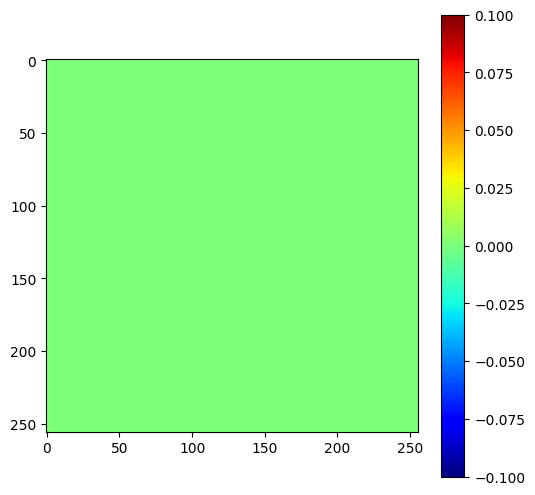

In [24]:
import matplotlib.pyplot as plt

# Assuming mask_array is loaded as before
plt.figure(figsize=(6,6))
plt.imshow(mask_array, cmap='jet')  # 'jet' is just one example of a colormap
plt.colorbar()  # To see the mapping between values and colors
plt.savefig('colored_mask.png')
plt.show()


### Important: we are fixing the data shuffling once and for all
This is achieved via seeding the shuffle and then seeding the train_test_split

In [ ]:
def shuffle_and_split(ds):
    ds_shuffled = ds.shuffle(seed=1)
    ds_shuffled_split = ds_shuffled["train"].train_test_split(test_size=0.2, seed=63, shuffle=False)
    train_ds = ds_shuffled_split["train"]
    test_ds = ds_shuffled_split["test"]
    return train_ds, test_ds

train_ds, test_ds = shuffle_and_split(ds)
train_ds_another, test_ds_another = shuffle_and_split(ds)

assert train_ds[0]['pixel_values'] == train_ds_another[0]['pixel_values']

In [8]:
# import os
# # Move up one directory from the current directory
# os.chdir(os.path.join(os.getcwd(), os.pardir))

# # Print the current directory to confirm the change
# print("Moved up to:", os.getcwd())
# folder = 'Test_images'
# os.chdir(os.path.join(os.getcwd(), folder))
# print("Moved up to:", os.getcwd())

Moved up to: c:\Users\rogbeast\Desktop\HeartProject\SegFormer
Moved up to: c:\Users\rogbeast\Desktop\HeartProject\SegFormer\Test_images


In [ ]:
path_to_save = "C:/Users/rogbeast/Desktop/HeartProject/SegFormer/Test_images"

In [ ]:

for feature in test_ds:
    print(feature)

In [ ]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

In [ ]:
from torchvision.transforms import ColorJitter
from transformers import (
    SegformerImageProcessor,
)

processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

new_transforms = NewProcessor()
def train_transforms_v2(example_batch):
    images = []; labels = []
    for image, label in zip(example_batch['pixel_values'], example_batch['label']):
        new_image, new_label = new_transforms(image, label)
        images.append(new_image)
        labels.append(new_label)
    inputs = processor(images, labels)
    return inputs

# NEW TRANSORMS WORK BETTER (slightly, but Baubek or Zhandos, we need more comprehensive measurements)
train_ds.set_transform(train_transforms_v2)
# train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
from transformers import SegformerForSemanticSegmentation

# pretrained_model_name = "nvidia/mit-b0"
# pretrained_model_name = "nvidia/mit-b1"
# pretrained_model_name = "nvidia/mit-b2"
pretrained_model_name = "nvidia/mit-b3"
# pretrained_model_name = "nvidia/mit-b4"
# pretrained_model_name = "nvidia/mit-b5"

model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Move your model to the selected device


### Better hardware efficiency
Previous settings were not efficient, let's use larger batch_size and evaluate less (e.g., only every 100 evals, or more)
Typically larger batch sizes use more hardware resources (thus efficiency) but tend to overfit, however we are controlling for overfitting with better regularization/data augmentation; see `NewProcessor` above

In [ ]:
from transformers import Trainer, AdamW, get_linear_schedule_with_warmup

class CustomTrainer(Trainer):
    def create_optimizer(self):
        """
        Create and return the custom optimizer.
        This replaces the default optimizer setup in Trainer.
        """
        optimizer = AdamW(self.model.parameters(), lr=self.args.learning_rate)
        return optimizer
    
    # def create_scheduler(self, num_training_steps: int):
    #     """
    #     Create and return the learning rate scheduler.
    #     """
    #     scheduler = get_linear_schedule_with_warmup(
    #         self.optimizer, 
    #         num_warmup_steps=0,  # Example value, adjust as needed
    #         num_training_steps=num_training_steps
    #     )
    #     return scheduler


In [ ]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR

In [ ]:
from transformers import TrainingArguments

epochs = 50
lr = 0.000001
# batch_size = 8
batch_size=8
# hub_model_id = "segformer-b4-seed17-feb-28-v2"
# hub_model_id = "segformer-b5-seed42-feb-29-v1"
hub_model_id = "segformer-b2-seed63-apr-13-v1"

training_args = TrainingArguments(
    "segformer-b3-seed63-outputs-v1",
    learning_rate=lr,
    # lr_scheduler='cosine',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

# Define Your Optimizer: 
#  Before setting a scheduler, you need to define an optimizer (e.g., SGD, Adam) with an initial learning rate.
#------
#torch.optim.lr_scheduler, such as 
#StepLR, 
#ExponentialLR, 
#ReduceLROnPlateau,
#CosineAnnealingLR,
training_args = training_args.set_lr_scheduler(name="cosine", warmup_ratio=0.05, max_steps=1000)
# training_args = training_args.set_lr_scheduler(name="exponential", gamma=0.96)
# training_args = training_args.set_lr_scheduler(name="step", step_size=100, gamma=0.1)


In [ ]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=test_ds,
#     compute_metrics=compute_metrics,
# )

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(test_ds)

In [ ]:
# default/initial settings from Baubek
# trainer.train()

In [ ]:
pretrained_model_name

In [ ]:
hf_dataset_identifier

In [ ]:
hub_model_id

In [ ]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

processor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)

In [ ]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
# nvidia/segformer-b3-finetuned-ade-512-512
# nvidia/segformer-b0-finetuned-ade-512-512
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(f"unreal-hug/{hub_model_id}")